In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import gc

import glob
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

# Data config
DATA_DIR = 'kaggle/input/vesuvius-challenge-ink-detection/'
BUFFER = 32  # Half-size of papyrus patches we'll use as model inputs
Z_DIM = 20   # Number of slices in the z direction. Max value is 64 - Z_START
Z_START = 16  # Offset of slices in the z direction
SHARED_HEIGHT = 4000  # Height to resize all papyrii

# Model config
BATCH_SIZE = 8
USE_MIXED_PRECISION = False
USE_JIT_COMPILE = False

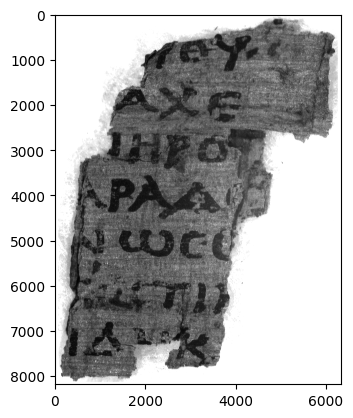

In [2]:
plt.imshow(Image.open(DATA_DIR + "train/1/ir.png"), cmap="gray")

# Load up training Data

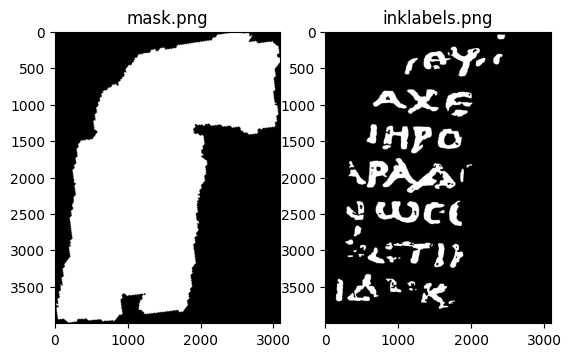

In [3]:
def resize(img):
    current_width, current_height = img.size
    aspect_ratio = current_width / current_height
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, SHARED_HEIGHT)
    img = img.resize(new_size)
    return img

def load_mask(split, index):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/mask.png").convert('1')
    img = resize(img)
    img_array = np.array(img)
    return tf.convert_to_tensor(img_array, dtype="bool")

def load_labels(split, index):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/inklabels.png")
    img = resize(img)
    img_array = np.array(img)
    return tf.convert_to_tensor(img_array, dtype="bool")

# Enable mixed precision training
if USE_MIXED_PRECISION:
    from tensorflow.keras import mixed_precision

    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)

mask = load_mask(split="train", index=1)
labels = load_labels(split="train", index=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()

In [4]:
mask_test_a = load_mask(split="test", index="a")
mask_test_b = load_mask(split="test", index="b")

mask_train_1 = load_mask(split="train", index=1)
labels_train_1 = load_labels(split="train", index=1)

mask_train_2 = load_mask(split="train", index=2)
labels_train_2 = load_labels(split="train", index=2)

mask_train_3 = load_mask(split="train", index=3)
labels_train_3 = load_labels(split="train", index=3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")

C:\NLP_Heat\Py\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


mask_test_a: (4000, 9284)
mask_test_b: (4000, 4642)
-
mask_train_1: (4000, 3094)
labels_train_1: (4000, 3094)
-
mask_train_2: (4000, 2563)
labels_train_2: (4000, 2563)
-
mask_train_3: (4000, 2760)
labels_train_3: (4000, 2760)


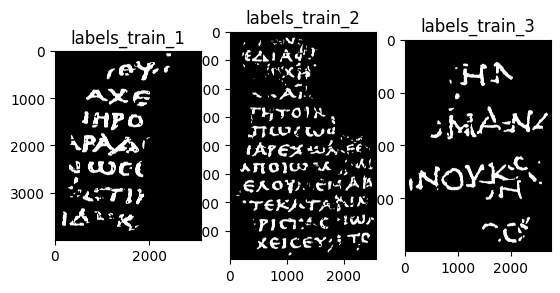

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("labels_train_1")
ax1.imshow(labels_train_1, cmap='gray')

ax2.set_title("labels_train_2")
ax2.imshow(labels_train_2, cmap='gray')

ax3.set_title("labels_train_3")
ax3.imshow(labels_train_3, cmap='gray')

plt.show()

In [6]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    z_slices_fnames = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = Image.open(filename)
        img = resize(img)
        z_slice = np.array(img, dtype="float16")
        z_slices.append(z_slice)
    return tf.stack(z_slices, axis=-1)

In [7]:
volume_train_1 = load_volume(split="train", index=1)
gc.collect()  # Free up memory
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")

volume_train_2 = load_volume(split="train", index=2)
gc.collect()  # Free up memory
print(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")

volume_train_3 = load_volume(split="train", index=3)
gc.collect()  # Free up memory
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

volume = tf.concat([volume_train_1, volume_train_2, volume_train_3], axis=1)
print(f"total volume: {volume.shape}")

del volume_train_1
del volume_train_2
del volume_train_3

20it [00:03,  5.74it/s]


volume_train_1: (4000, 3094, 20), <dtype: 'float16'>


20it [00:02,  6.69it/s]


volume_train_2: (4000, 2563, 20), <dtype: 'float16'>


20it [00:02,  7.00it/s]


volume_train_3: (4000, 2760, 20), <dtype: 'float16'>
total volume: (4000, 8417, 20)


In [8]:
labels = tf.concat([labels_train_1, labels_train_2, labels_train_3], axis=1)
print(f"labels: {labels.shape}, {labels.dtype}")

mask = tf.concat([mask_train_1, mask_train_2, mask_train_3], axis=1)
print(f"mask: {mask.shape}, {mask.dtype}")

# Free up memory
del labels_train_1
del labels_train_2
del labels_train_3
del mask_train_1
del mask_train_2
del mask_train_3

labels: (4000, 8417), <dtype: 'bool'>
mask: (4000, 8417), <dtype: 'bool'>


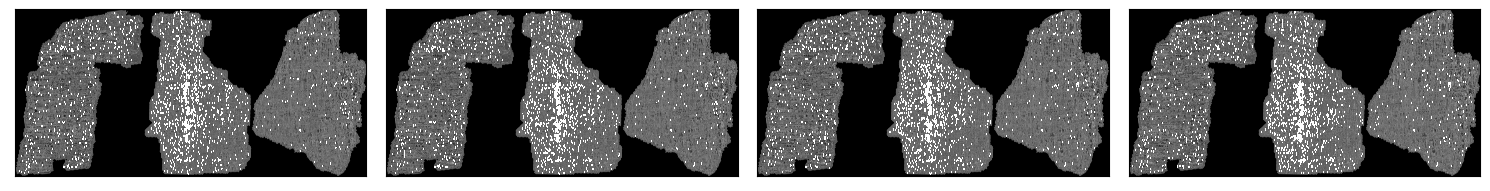

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for z, ax in enumerate(axes):
    ax.imshow(volume[:, :, z], cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

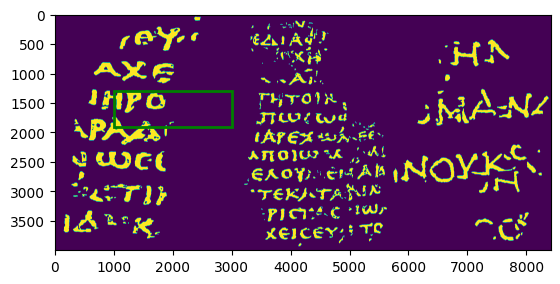

In [10]:
val_location = (1300, 1000)
val_zone_size = (600, 2000)

fig, ax = plt.subplots()
ax.imshow(labels)
patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()

In [11]:
def sample_random_location(shape):
    random_train_x = tf.random.uniform(shape=(), minval=BUFFER, maxval=shape[0] - BUFFER - 1, dtype="int32")
    random_train_y = tf.random.uniform(shape=(), minval=BUFFER, maxval=shape[1] - BUFFER - 1, dtype="int32")
    random_train_location = tf.stack([random_train_x, random_train_y])
    return random_train_location

def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]]

sample_random_location_train = lambda x: sample_random_location(mask.shape)
is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

def is_in_val_zone(location, val_location, val_zone_size):
    x = location[0]
    y = location[1]
    x_match = val_location[0] - BUFFER <= x <= val_location[0] + val_zone_size[0] + BUFFER
    y_match = val_location[1] - BUFFER <= y <= val_location[1] + val_zone_size[1] + BUFFER
    return x_match and y_match

def is_proper_train_location(location):
    return not is_in_val_zone(location, val_location, val_zone_size) and is_in_mask_train(location)

train_locations_ds = tf.data.Dataset.from_tensor_slices([0]).repeat().map(sample_random_location_train, num_parallel_calls=tf.data.AUTOTUNE)
train_locations_ds = train_locations_ds.filter(is_proper_train_location)

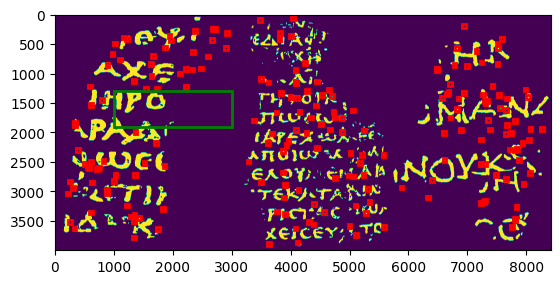

In [12]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in train_locations_ds.take(200):
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

val_patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(val_patch)
plt.show()

In [13]:
def extract_subvolume(location, volume):
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :]
    subvolume = tf.cast(subvolume, dtype="float32") / 65535.
    return subvolume

def extract_labels(location, labels):
    x = location[0]
    y = location[1]
    label = labels[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER]
    label = tf.cast(label, dtype="float32")
    label = tf.expand_dims(label, axis=-1)
    return label

def extract_subvolume_and_label(location):
    subvolume = extract_subvolume(location, volume)
    label = extract_labels(location, labels)
    return subvolume, label

shuffle_buffer_size = BATCH_SIZE * 4

train_ds = train_locations_ds.map(extract_subvolume_and_label, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

In [14]:
for subvolume_batch, label_batch in train_ds.take(1):
    print(f"subvolume shape: {subvolume_batch.shape[1:]}")
    print(f"label_batch shape: {label_batch.shape[1:]}")

subvolume shape: (64, 64, 20)
label_batch shape: (64, 64, 1)


In [15]:
t0 = time.time()
n = 200
for _ in train_ds.take(n):
    pass
print(f"Time per batch: {(time.time() - t0) / n:.4f}s")

Time per batch: 0.0043s


In [16]:
val_locations_stride = BUFFER
val_locations = []
for x in range(val_location[0], val_location[0] + val_zone_size[0], val_locations_stride):
    for y in range(val_location[1], val_location[1] + val_zone_size[1], val_locations_stride):
        val_locations.append((x, y))

val_locations_ds = tf.data.Dataset.from_tensor_slices(val_locations).filter(is_in_mask_train)
val_ds = val_locations_ds.map(extract_subvolume_and_label, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

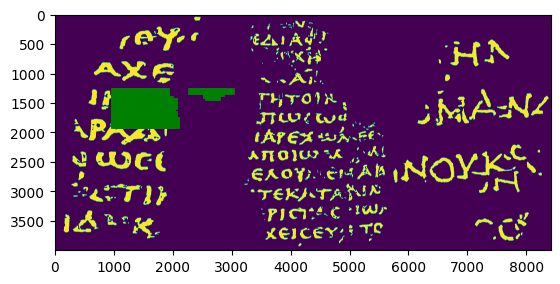

In [17]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in val_locations_ds:
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(patch)
plt.show()

In [18]:
def trivial_baseline(dataset):
    total = 0
    matches = 0.
    for _, batch_label in tqdm(dataset):
        matches += tf.reduce_sum(tf.cast(batch_label, "float32"))
        total += tf.reduce_prod(tf.shape(batch_label))
    return 1. - matches / tf.cast(total, "float32")

score = trivial_baseline(val_ds).numpy()
print(f"Best validation score achievable trivially: {score * 100:.2f}% accuracy")

82it [00:00, 118.84it/s]

Best validation score achievable trivially: 76.03% accuracy


In [19]:
augmenter = keras.Sequential([
    layers.RandomContrast(0.2),
])

def augment_train_data(data, label):
    data = augmenter(data)
    return data, label

augmented_train_ds = train_ds.map(augment_train_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [ ]:
def get_model(input_shape):
    inputs = keras.Input(input_shape)
    
    x = inputs
    
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

if USE_MIXED_PRECISION:
    keras.mixed_precision.set_global_policy('mixed_float16')

model = get_model((BUFFER * 2, BUFFER * 2, Z_DIM))
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"], jit_compile=USE_JIT_COMPILE)

model.fit(augmented_train_ds, validation_data=val_ds, epochs=20, steps_per_epoch=1000)
model.save("model.keras")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 20)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   11584       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 16, 16, 128)  295040     ['activation_6[0][0]']           
 spose)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 16, 16, 128)  512        ['conv2d_transpose_2[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 128)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 16, 16, 128)  147584     ['activation_7[0][0]']           
 spose)   

In [ ]:
del volume
del mask
del labels
del train_ds
del val_ds

# Manually trigger garbage collection
keras.backend.clear_session()
import gc
gc.collect()

model = keras.models.load_model("model.keras")